In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os
from PIL import Image
from sklearn.model_selection import train_test_split

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [3]:
# from skmultilearn.model_selection import iterative_train_test_split
# t_train, y_train, t_test, y_test = iterative_train_test_split(X, y, test_size = 0.2)

In [2]:
# Dataset Load and split

# 96 eyes, 49 OCT images, 2 visits, 16 biomarkers (binary)
# 96 eyes, 49 OCT images, 2 visits, 496 x 504 OCT images (grayscale)
scan_N = 9408
oct_N = 49
eye_N = 96
sh = [496, 504]

csv_file = '~/scratch/OLIVES/OLIVES/Biomarker_Clinical_Data_Images_Updated.csv'
data = pd.read_csv(csv_file)
col_names = data.columns
file_paths = data['Path (Trial/Arm/Folder/Visit/Eye/Image Name)'].values #[9408,]
file_paths = file_paths.reshape([eye_N,2*oct_N])
bio_markers = data[col_names[2:18]].values
bio_markers = bio_markers.reshape([eye_N,2*oct_N,-1])

clin_data = data[col_names[19:21]].values
clin_data = clin_data.reshape([eye_N,2*oct_N,-1])

home_dir = '/home/hice1/hsuh45/scratch/OLIVES/OLIVES/'



In [3]:
# Check for rows with Nan and identify the rows (get rid of them after Data split)
rows_with_nan = data[data.isna().any(axis=1)]
# data = data.dropna()

In [13]:
# DeiT preprocessing
# transform_deit = transforms.Compose([
#     transforms.Resize((512,512)),                # Resize to square dimensions
#     transforms.ToTensor(),                        # Convert to tensor
#     transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize (adjust mean/std for grayscale)
# ])
# SwinT preprocessing
# resize to square + fit the input size (due to small dataset)


########## Preprocessing ###########################
model_name = 'deit_base_patch16_224'
input_dim = 224
transform_swin = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.CenterCrop(496),
    transforms.Resize((input_dim,input_dim)),                # 224x224 or 384x384
    transforms.ToTensor(),                        # Convert to tensor
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalize with ImageNet stats
        std=[0.229, 0.224, 0.225])
])

#####################################################

# Create DataLoaders with the preprocessed data
class OCTDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        
        img = Image.open(home_dir + self.file_paths[index][0]).convert("L")
        label = self.labels[index]  # Shape: [sample N, bio_marker_N]
        
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(label, dtype=torch.float32)
        
        return img, label

########## Get rid of Nan values in bio_markers ###########
nan_rows = np.isnan(bio_markers).any(axis=2)  # Shape (96, 98), True where NaNs are present
print(np.sum(nan_rows))
# Replace NaN rows with alternating 1 and -1
alternating_row = np.tile([1, -1], 8)  # Alternating 1 and -1, length 16 (biomarker dimension)
bio_markers[nan_rows] = alternating_row

###### Split dataset into train/val/test (based on number of positives)


pos_count = np.sum(bio_markers,axis=(1,2)) # pos label count per eye
bins = [0,200,300,400,np.inf]
print(pos_count)
stratify_bins = np.digitize(pos_count, bins)
print(stratify_bins)
train_val_files, test_files, train_val_labels, test_labels = train_test_split(
    file_paths, bio_markers, test_size=0.2,
    stratify = stratify_bins,
    random_state=42
)

pos_count = np.sum(train_val_labels,axis=(1,2)) # pos label count per eye
bins = [0,200,300,400,np.inf]
stratify_bins = np.digitize(pos_count, bins)
print(pos_count)
train_files, val_files, train_labels, val_labels = train_test_split(
    train_val_files, train_val_labels, test_size=0.25, 
    stratify = stratify_bins,
    random_state=42
)
print(train_files.shape, val_files.shape, test_files.shape)

##############################################################


# Eye-wise -> scan-wise
train_files = train_files.reshape([-1,1])
val_files = val_files.reshape([-1,1])
test_files = test_files.reshape([-1,1])

train_labels = train_labels.reshape([-1,16])
val_labels = val_labels.reshape([-1,16])
test_labels = test_labels.reshape([-1,16])

######## Get rid of data points with Nan values #########
def remove_marked_rows(files, labels):
    # Identify rows where any column has -1 (our marker for NaNs)
    marked_rows = (labels == -1).all(axis=1) # shape(N,16)
    filtered_labels = labels[~marked_rows]
    filtered_files = files[~marked_rows]
    return filtered_files, filtered_labels

# print(train_labels)
train_files, train_labels = remove_marked_rows(train_files, train_labels)
val_files, val_labels = remove_marked_rows(val_files, val_labels)
test_files, test_labels = remove_marked_rows(test_files, test_labels)

#########################################################

train_dataset = OCTDataset(train_files, train_labels, transform=transform_swin)
val_dataset = OCTDataset(val_files, val_labels, transform=transform_swin)
test_dataset = OCTDataset(test_files, test_labels, transform=transform_swin)

# Make DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

(57, 98) (19, 98) (20, 98)


In [4]:
img = Image.open(home_dir + file_paths[0][0])
np.array(img).shape
train_labels[0]

array([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

(array([ 2.,  6.,  8.,  9., 11., 10.,  9., 13.,  4.,  4.]),
 array([ 96. , 131.6, 167.2, 202.8, 238.4, 274. , 309.6, 345.2, 380.8,
        416.4, 452. ]),
 <BarContainer object of 10 artists>)

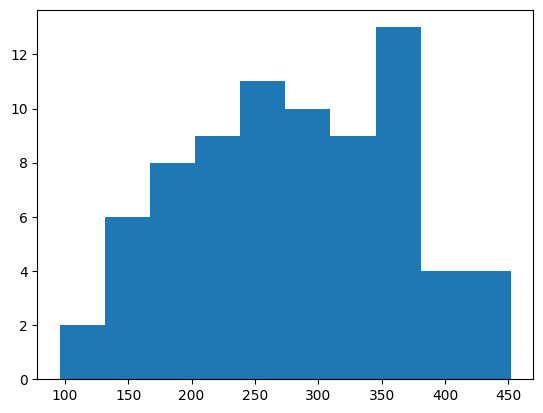

In [5]:
# Check pos_sum distribution for stratification label
import matplotlib.pyplot as plt
plt.hist(np.sum(train_val_labels, axis=(1,2)))

In [7]:
train_files.shape

(5586, 16)

In [18]:
np.isnan(test_labels).sum()
bio_markers.shape

(96, 98, 16)

In [6]:
# Quick analysis of biomarker distribution

print(np.sum(train_labels, axis=(0)) / np.sum(train_labels))
print(np.sum(val_labels, axis=(0)) / np.sum(val_labels))

print(np.sum(train_labels, axis=(0))/train_labels.shape[0])
print(np.sum(val_labels, axis=(0))/val_labels.shape[0])
# discrepancy between train vs val class distribution (not too severe (?))

print(np.sum(bio_markers,axis=(0,1)) / (bio_markers.shape[0]*bio_markers.shape[1]))


[ 0.007287    0.02192327  0.00274041  0.01033881  0.22732935  0.10812157
  0.20204285  0.0297708   0.12176134 -0.00031141  0.1114848   0.14798206
  0.00772297 -0.00043597  0.0013702   0.00087195]
[0.00923077 0.0225     0.         0.00923077 0.24961538 0.11442308
 0.18403846 0.0325     0.09365385 0.00057692 0.10557692 0.16153846
 0.01134615 0.00076923 0.         0.005     ]
[ 0.02094522  0.06301468  0.00787683  0.02971715  0.65341926  0.31077694
  0.58073756  0.08557107  0.3499821  -0.00089509  0.32044397  0.42534909
  0.02219835 -0.00125313  0.00393842  0.00250627]
[0.02577873 0.06283566 0.         0.02577873 0.69709989 0.31954887
 0.51396348 0.09076262 0.26154672 0.00161117 0.29484425 0.45112782
 0.03168636 0.00214823 0.         0.01396348]
[ 1.89200680e-02  6.29251701e-02  4.67687075e-03  3.83715986e-02
  6.74957483e-01  3.15901361e-01  5.55697279e-01  8.45025510e-02
  3.02721088e-01 -2.12585034e-04  3.20471939e-01  4.33142007e-01
  2.60416667e-02 -2.12585034e-04  2.33843537e-03  6.8

In [7]:
# !pip install timm
torch.cuda.is_available()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


True

In [8]:
# Weighted BCE for multi-label imbalanced (pos vs. neg) data

train_pos_weights = train_labels.shape[0] / (2* np.sum(train_labels,axis=0))
# val_pos_weights = val_labels.shape[0] / (2* np.sum(val_labels,axis=0))
# test_pos_weights = test_labels.shape[0] / (2* np.sum(test_labels,axis=0))

class WeightedBinaryCrossEntropyLoss(nn.Module):
    def __init__(self, pos_weights):
        """
        pos_weights: Tensor of shape (num_biomarkers,) containing weights for positive labels.
        """
        super(WeightedBinaryCrossEntropyLoss, self).__init__()
        self.pos_weights = pos_weights

    def forward(self, logits, targets):
        """
        logits: Predicted logits from the model, shape (batch_size, num_biomarkers).
        targets: Ground truth binary labels, shape (batch_size, num_biomarkers).
        """
        loss = nn.BCEWithLogitsLoss(reduction='none')(logits, targets)  # Compute BCE loss
        weighted_loss = loss * self.pos_weights  # Apply positive weights
        return weighted_loss.mean()

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        """
        Focal Loss for multi-label classification.

        Parameters:
        - gamma (float): Focusing parameter that reduces the loss for well-classified samples (default: 2.0).
        - alpha (float or Tensor): Balancing factor to address class imbalance (default: None).
          If a tensor is provided, it should be of shape (num_classes,).
        - reduction (str): Specifies the reduction to apply to the output: 'none', 'mean', 'sum' (default: 'mean').
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, targets):
        """
        Compute Focal Loss.

        Parameters:
        - logits (Tensor): Predicted logits of shape (batch_size, num_classes).
        - targets (Tensor): Ground truth labels of shape (batch_size, num_classes).

        Returns:
        - loss (Tensor): Calculated focal loss.
        """
        # Convert logits to probabilities using sigmoid
        probs = torch.sigmoid(logits)
        
        # Binary cross-entropy loss
        bce_loss = F.binary_cross_entropy(probs, targets, reduction='none')
        
        # Compute the modulating factor (1 - p_t)^gamma
        pt = probs * targets + (1 - probs) * (1 - targets)
        focal_factor = (1 - pt) ** self.gamma

        # Apply class balancing factor alpha if provided
        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            elif isinstance(self.alpha, torch.Tensor):
                alpha_factor = self.alpha.unsqueeze(0) * targets + (1 - self.alpha).unsqueeze(0) * (1 - targets)
            else:
                raise ValueError("Alpha must be a float, int, or torch.Tensor.")
            focal_loss = alpha_factor * focal_factor * bce_loss
        else:
            focal_loss = focal_factor * bce_loss

        # Reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Initialize Focal Loss (Example)
# 1. gamma (Focusing Parameter):
# Controls the strength of the focusing effect.
# Higher values put more focus on hard-to-classify samples.

# 2. alpha (Class Balancing Factor):
# Helps address class imbalance.
# If alpha is a scalar, it applies the same balancing for all classes.
# If alpha is a tensor, it applies per-class balancing.

# 3. reduction:
# 'mean': Average loss across the batch.
# 'sum': Sum of the loss across the batch.
# 'none': No reduction is applied; returns loss for each sample.

focal_loss = FocalLoss(gamma=2.0, alpha=0.25)


In [15]:
import timm 
import tqdm


# Load model (model_name, )
# model_name = 'deit_base_patch16_224'
# input_dim = 224
print(f'model name {model_name}, input size {input_dim}')
model = timm.create_model(model_name, pretrained=True) 


print(model.head)
###### Parameters ######
lr = 1e-4
num_classes = 16
epochs = 10
########################

# Modify the classifier head for multi-class output
model.head = nn.Sequential(
    nn.Linear(model.head.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes),  # 16 biomarkers
    nn.Sigmoid()  # Multi-label classification (probabilities for each class)
)

print(model.head)
model = model.to('cuda')

# Freeze Vision Encoder layers if needed
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW(model.head.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

##########Loss ##################

criterion = torch.nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
# criterion = WeightedBinaryCrossEntropyLoss(train_pos_weights)
# criterion = FocalLoss(gamma=2.0, alpha=0.25)
#################################

# Training and validation
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm.tqdm(train_loader):
        images, labels = images.to('cuda'), labels.to('cuda')
#         print(images.shape, labels.shape)

        optimizer.zero_grad()
        outputs = model(images)
#         print(outputs.shape, labels.shape, images.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)

def validate_one_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm.tqdm(val_loader):
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            all_outputs.append(outputs.cpu())
            all_labels.append(labels.cpu())

    return (running_loss / len(val_loader)), all_outputs, all_labels

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_outputs, val_labels = validate_one_epoch(model, val_loader, criterion)
    
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    scheduler.step()

# Test the model
# def test_model(model, test_loader, device):
#     model.eval()
#     correct = 0
#     total = 0
#     threshold = 0.5
#     with torch.no_grad():
#         for images, labels in test_loader:
#             images, labels = images.to('cuda'), labels.to('cuda')
#             outputs = model(images)
#             predictions = (outputs > threshold).float()  # Threshold at 0.5 for binary decisions
#             correct += (predictions == labels).sum().item()
#             total += labels.numel()

#     accuracy = correct / total
#     print(f"Test Accuracy: {accuracy * 100:.2f}%")

# # Evaluate on test set
# test_model(model, test_loader, device)

Linear(in_features=768, out_features=1000, bias=True)
Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=16, bias=True)
  (4): Sigmoid()
)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Optimize biomarker-wise threshold for validation on eval metrics

def optimal_thresholds(model_outputs, labels, metric='f1'):
    """
    Calculate optimal thresholds for each biomarker.
    
    Parameters:
        model_outputs (ndarray): Model predictions, shape (N, 16) where N is the number of samples.
        labels (ndarray): True binary labels, shape (N, 16).
        metric (str): Metric to optimize. Options: 'f1', 'auc'.

    Returns:
        thresholds (list): Optimal threshold for each biomarker.
        scores (list): Corresponding best scores for each biomarker.
    """
    num_biomarkers = model_outputs.shape[1]
    thresholds = []
    scores = []
    
    for i in range(num_biomarkers):
        best_threshold = 0.0
        best_score = 0.0
        
        # Thresholds to search
        thresholds_range = np.linspace(0, 1, 100)
        
        for threshold in thresholds_range:
            preds = (model_outputs[:, i] >= threshold).astype(int)
            
            if metric == 'f1':
                score = sklearn.metrics.f1_score(labels[:, i], preds)
            elif metric == 'auc':
                # AUC does not depend on a threshold
                score = sklearn.metrics.roc_auc_score(labels[:, i], model_outputs[:, i])
                best_threshold = None  # No threshold needed for AUC
                break
            else:
                raise ValueError("Unsupported metric. Use 'f1' or 'auc'.")
            
            if score > best_score:
                best_score = score
                best_threshold = threshold
        
        thresholds.append(best_threshold)
        scores.append(best_score)
    
    return thresholds, scores

f1_th, f1_scores = optimal_thresholds(val_outputs, val_labels, metric='f1')
auc_th, auc_scores = optimal_thresholds(val_outputs, val_labels, metric='auc')
print(f'F1 threshold {f1_th}, F1 validation scores {f1_scores})
print(f'AUC threshold {auc_th}, AUC validation scores {auc_scores})
      

In [25]:
# Get output, save output, get F1 scores and AUC 
import sklearn
test_shape = test_labels.shape

model.eval()
correct = 0
total = 0
############################################
threshold = f1_th # F1 vs. AUC threshold
threshold = threshold.reshape(1,16)
############################################
model_output = np.zeros(test_shape)
target = np.zeros(test_shape)
pred = np.zeros(test_shape)
batch_size = 32

with torch.no_grad():
    for batch, (images, labels) in enumerate(test_loader):
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model(images)
        model_output[batch*batch_size: (batch+1)*batch_size] = outputs
        pred[batch*batch_size: (batch+1)*batch_size] = (outputs > threshold).float().cpu()  # Threshold at 0.5 for binary decisions
        target[batch*batch_size: (batch+1)*batch_size] = labels.cpu()

print("Finished iteration")
# print(pred[0])
# print(target[0])
for i in range(num_classes):
    f1 = sklearn.metrics.f1_score(target[:,i], pred[:,i], zero_division =0)
    try:
        auc = sklearn.metrics.roc_auc_score(target[:,i],pred[:,i])
    except ValueError:
        auc = np.nan
    print(f1, auc)


Finished iteration
[0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0.0 0.5
0.0 0.5
0.0 0.5
0.08571428571428572 0.5234961383661482
0.8512679917751885 0.7004670206640651
0.3918799646954987 0.5852806999180057
0.6673407482305359 0.6723738922057378
0.0213903743315508 0.5041510611735331
0.3088512241054614 0.5859964787220338
0.0 0.5
0.8469860896445132 0.8742755553127461
0.8386363636363636 0.8520721444226941
0.31746031746031744 0.5943396226415094
0.0 0.5
0.0 nan
0.0 0.5
